# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_2906508/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [11]:
protocol_name = "rc_om_and_comp"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = "./data"

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [14]:
raw_data_glob_pattern = "./data/spikegadgets"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [15]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [16]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [17]:
raw_data_file_path

'./data/spikegadgets'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [18]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/__pycache__/nancyprobe_linearprobelargespace.cpython-39.pyc
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


file prefix: dio_ECU_Dout27.dat
directory prefix: DIO
file prefix: dio_ECU_Din16.dat
directory prefix: DIO
file prefix: dio_ECU_Dout12.dat
directory prefix: DIO
file prefix: dio_ECU_Dout14.dat
directory prefix: DIO
file prefix: dio_ECU_Dout21.dat
directory prefix: DIO
file prefix: dio_ECU_Dout17.dat
directory prefix: DIO
file prefix: dio_ECU_Dout28.dat
directory prefix: DIO
file prefix: dio_ECU_Dout9.dat
directory prefix: DIO
file prefix: dio_ECU_Din7.dat
directory prefix: DIO
file prefix: dio_ECU_Din21.dat
directory prefix: DIO
file prefix: dio_ECU_Din29.dat
directory prefix: DIO
file prefix: dio_ECU_Dout16.dat
directory prefix: DIO
file prefix: dio_ECU_Dout1.dat
directory prefix: DIO
file prefix: dio_Controller_Din3.dat
directory prefix: DIO
file prefix: dio_ECU_Din19.dat
directory prefix: DIO
file prefix: dio_ECU_Dout29.dat
directory prefix: DIO
file prefix: dio_ECU_Dout25.dat
directory prefix: DIO
file prefix: dio_ECU_Dout18.dat
directory prefix: DIO
file prefix: dio_ECU_Din20.dat


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/20221215_145401_comp_amd_om_6_1_top_4_base_3.trodesconf
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/logger_raw.dat
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/proj

file prefix: analog_ECU_Ain2.dat
directory prefix: analog
file prefix: analog_ECU_Ain6.dat
directory prefix: analog
file prefix: analog_ECU_Ain5.dat
directory prefix: analog
file prefix: analog_ECU_Ain1.dat
directory prefix: analog
file prefix: analog_Headstage_GyroY.dat
directory prefix: analog
file prefix: analog_ECU_Ain7.dat
directory prefix: analog
file prefix: analog_Headstage_AccelY.dat
directory prefix: analog
file prefix: analog_Headstage_AccelZ.dat
directory prefix: analog
file prefix: analog_Headstage_GyroX.dat
directory prefix: analog
file prefix: analog_ECU_Ain8.dat
directory prefix: analog
file prefix: analog_Controller_Ain1.dat
directory prefix: analog
file prefix: analog_ECU_Ain3.dat
directory prefix: analog
file prefix: analog_Headstage_GyroZ.dat
directory prefix: analog
file prefix: analog_Headstage_AccelX.dat
directory prefix: analog
file prefix: analog_ECU_Ain4.dat
directory prefix: analog
file prefix: timestamps.dat
directory prefix: analog
file prefix: analog_Heads

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/20221215_145401_comp_amd_om_6_1_top_4_base_3.timestampoffset/20221215_145401_comp_amd_om_6_1_top_4_base_3.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/20221215_145401_comp_

file prefix: timestamps.dat
directory prefix: stimulation
file prefix: group0.coordinates.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: kilosort
file prefix: spikes_nt22.dat
directory prefix: spikes


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_02_02_rc_om_ephys_preprocessing/subject_6_1/20221215/data/spikegadgets/20221215_145401_comp_amd_om_6_1_top_4_base_3.kilosort/20221215_145401_comp_amd_om_6_1_top_4_base_3.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))


file prefix: spikes_nt16.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt12.dat
directory prefix: spikes
file prefix: spikes_nt8.dat
directory prefix: spikes
file prefix: spikes_nt29.dat
directory prefix: spikes
file prefix: spikes_nt25.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt1.dat
directory prefix: spikes
file prefix: spikes_nt9.dat
directory prefix: spikes
file prefix: spikes_nt20.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt24.dat
directory prefix: spikes
file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt30.dat
direct

- All the folders that were extracted from

In [19]:
file_to_data.keys()

dict_keys(['__pycache__', '20221215_145401_comp_amd_om_6_1_top_4_base_3.DIO', 'DIO', '20221215_145401_comp_amd_om_6_1_top_4_base_3.spikeband', 'spikeband', '20221215_145401_comp_amd_om_6_1_top_4_base_3.raw', 'raw', '.', '20221215_145401_comp_amd_om_6_1_top_4_base_3.analog', 'analog', '20221215_145401_comp_amd_om_6_1_top_4_base_3.time', 'time', '20221215_145401_comp_amd_om_6_1_top_4_base_3.LFP', 'LFP', '20221215_145401_comp_amd_om_6_1_top_4_base_3.timestampoffset', '20221215_145401_comp_amd_om_6_1_top_4_base_3.mountainsort', 'mountainsort', '20221215_145401_comp_amd_om_6_1_top_4_base_3.stimulation', 'stimulation', '20221215_145401_comp_amd_om_6_1_top_4_base_3.kilosort', 'kilosort', '20221215_145401_comp_amd_om_6_1_top_4_base_3.spikes', 'spikes'])

- Looking over all the extracted data

In [20]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: __pycache__
Directory: 20221215_145401_comp_amd_om_6_1_top_4_base_3.DIO
	File Name: dio_ECU_Dout27.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: State change data for one digital channel. Display_order is 1-based

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221215_145401_comp_amd_om_6_1_top_4_base_3.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Typ

	 	 Data Value: [([  709,   566,   799,   820,   768,   853,   696,   559,   743,   928,  1005,   769,   650,   -82, -1220,   223,    79,   643,   857,   665,   721,   874,   934,   806,   898,   759,   914,   871,   770,   992,   898,   884],)
 ([  694,   658,   736,   779,   947,   845,   700,   515,   796,   909,   939,   773,   742,  -213, -1296,   121,    51,   607,   678,   686,   702,   814,   899,   911,   834,   716,   861,   869,   659,   934,   947,   805],)
 ([  654,   608,   622,   678,   826,   785,   642,   543,   809,   967,   886,   677,   715,  -264, -1374,   104,    38,   638,   696,   755,   675,   748,   884,   731,   775,   567,   770,   711,   607,   840,   914,   737],)
 ...
 ([ -508,  -133,  -399,  -421,  -116,  -744,  -515,  -461,  -498,  -335,  -504,  -211,  -304,  -657,  -137,   985,  -865,  -203,  -133,  -186,  -295,  -559,  -452,  -347,  -295,  -565,  -479,  -476,  -362,  -296,  -273,  -269],)
 ([ -464,  -219,  -375,  -286,  -152,  -932,  -522,  -463,  -52

# Part 2: Looking over the data

## Looking over the MED-PC Data

- Box 1 Port Entries
    - ECU Din3
- Box 2 Port Entries
    - Controller Din1
- Box 1 Tone playing
    - ECU Din1

In [21]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [22]:
DIO_directory_name

'DIO'

In [23]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [24]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout27.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Dout12.dat', 'dio_ECU_Dout14.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Dout28.dat', 'dio_ECU_Dout9.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Din21.dat', 'dio_ECU_Din29.dat', 'dio_ECU_Dout16.dat', 'dio_ECU_Dout1.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Dout29.dat', 'dio_ECU_Dout25.dat', 'dio_ECU_Dout18.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Din28.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Dout31.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Dout19.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Din10.dat', 'dio_Controller_Din5.dat', 'dio_Controller_Din1.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Din5.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Dout22.dat', 'dio_ECU_Din11.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din2.dat', 'dio_ECU_Dout24.dat', 'dio_ECU_Dout2.dat', 'dio_ECU_Dout4.dat', 'dio_Controller_Din4.dat', 'dio_ECU_Din15.dat', 'dio_ECU_Dout32.dat', 'dio_ECU_Din17.dat', 'dio_ECU_

### Tone Onset Signal

In [25]:
tone_onset_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [26]:
tone_onset_DIN_file_name

'dio_ECU_Din1.dat'

In [27]:
tone_onset_DIN_state_array = DIO_directory_dict[tone_onset_DIN_file_name]["data"]

In [28]:
tone_onset_DIN_state_array

array([( 1049104, 1), ( 1721402, 0), ( 2921801, 1), ( 3121800, 0),
       ( 4521798, 1), ( 4721798, 0), ( 6321793, 1), ( 6521795, 0),
       ( 7921790, 1), ( 8121790, 0), ( 9421790, 1), ( 9621790, 0),
       (11421788, 1), (11621787, 0), (13321785, 1), (13521784, 0),
       (15121782, 1), (15321781, 0), (16721780, 1), (16921779, 0),
       (18521777, 1), (18721774, 0), (20521771, 1), (20721773, 0),
       (22321771, 1), (22521768, 0), (24721768, 1), (24921767, 0),
       (26521765, 1), (26721762, 0), (28221763, 1), (28421762, 0),
       (30021760, 1), (30221760, 0), (31921758, 1), (32121757, 0),
       (34321752, 1), (34521754, 0), (35921752, 1), (36121751, 0),
       (38921346, 1), (42353344, 0), (43553742, 1), (43753741, 0),
       (45153740, 1), (45353737, 0), (46953737, 1), (47153737, 0),
       (48553736, 1), (48753733, 0), (50053734, 1), (50253733, 0),
       (52053731, 1), (52253730, 0), (53953729, 1), (54153728, 0),
       (55753726, 1), (55953724, 0), (57353724, 1), (57553722,

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

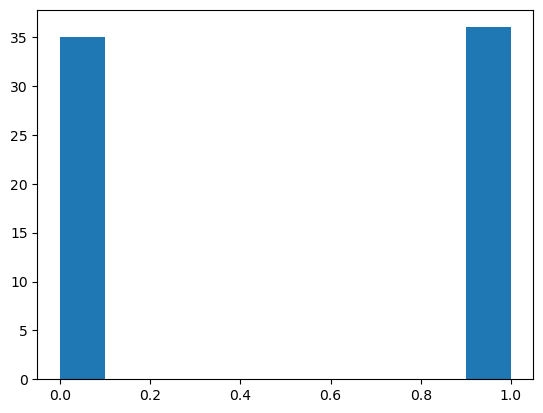

In [29]:
plt.hist([tup[1] for tup in tone_onset_DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

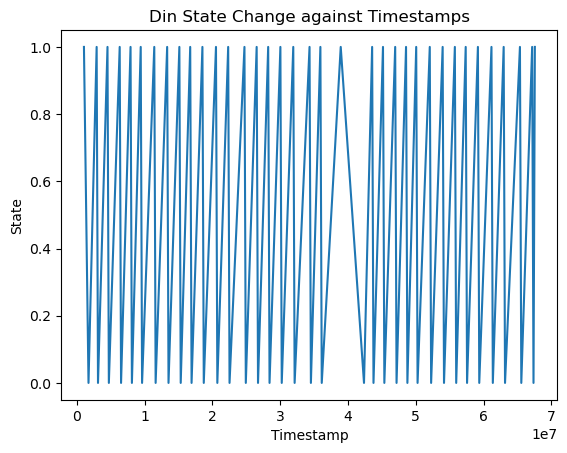

In [30]:
plt.plot([tup[0] for tup in tone_onset_DIN_state_array], [tup[1] for tup in tone_onset_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 1 Port Entries

In [31]:
box1_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din3.dat", return_first=True)

In [32]:
box1_port_entries_DIN_file_name

'dio_ECU_Din3.dat'

In [33]:
box1_port_entries_DIN_state_array = DIO_directory_dict[box1_port_entries_DIN_file_name]["data"]

In [34]:
box1_port_entries_DIN_state_array

array([( 1049104, 1), ( 1721402, 0), ( 1913602, 1), ..., (67505712, 1),
       (67524911, 0), (67553314, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([1594.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1595.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

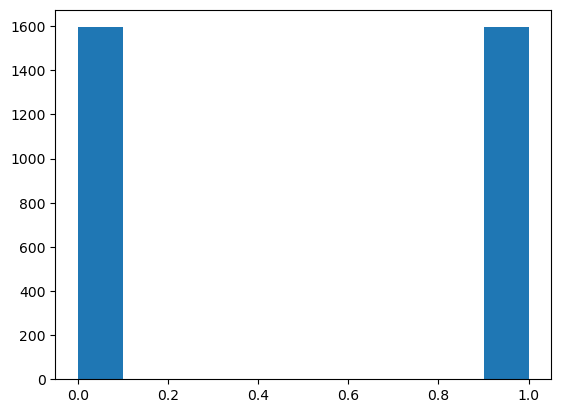

In [35]:
plt.hist([tup[1] for tup in box1_port_entries_DIN_state_array])

- There is a gap in the middle when the protocol was being changed between competition or omission

Text(0.5, 1.0, 'Din State Change against Timestamps')

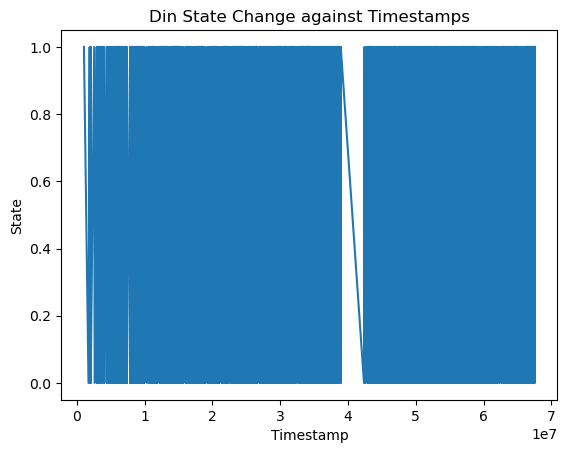

In [36]:
plt.plot([tup[0] for tup in box1_port_entries_DIN_state_array], [tup[1] for tup in box1_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 2 Port Entries

In [37]:
box2_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="dio_Controller_Din1.dat", return_first=True)

In [38]:
box2_port_entries_DIN_file_name

'dio_Controller_Din1.dat'

In [39]:
box2_port_entries_DIN_file_name = DIO_directory_dict[box2_port_entries_DIN_file_name]["data"]

In [40]:
box2_port_entries_DIN_file_name

array([( 1049104, 1), (42353342, 0), (42353742, 1), (42424741, 0),
       (42429339, 1), (42435339, 0), (42449741, 1), (42450541, 0),
       (42452941, 1), (42455539, 0), (42457341, 1), (42458139, 0),
       (42609341, 1), (42657341, 0), (42659941, 1), (42661141, 0),
       (42661539, 1), (42667139, 0), (42671339, 1), (42673539, 0),
       (42674939, 1), (42675739, 0), (42676739, 1), (42679141, 0),
       (42694341, 1), (42781741, 0), (42782738, 1), (42904741, 0),
       (42908738, 1), (42920538, 0), (42988338, 1), (43012138, 0),
       (43012541, 1), (43028138, 0), (43028541, 1), (43033738, 0),
       (43035538, 1), (43037141, 0), (43041941, 1), (43054138, 0),
       (43054538, 1), (43056741, 0), (43068941, 1), (43091541, 0),
       (43486540, 1), (43490738, 0), (43494740, 1), (43529340, 0),
       (43534740, 1), (43549740, 0), (43580540, 1), (43842137, 0),
       (43882940, 1), (43925739, 0), (44133139, 1), (44182739, 0),
       (44248139, 1), (44274939, 0), (44324739, 1), (44355736,

(array([307.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 308.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

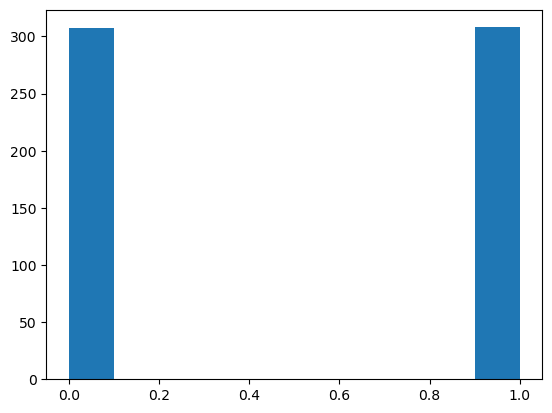

In [41]:
plt.hist([tup[1] for tup in box2_port_entries_DIN_file_name])

- This is half the time than the previous port entries, because the mouse was moved to box 1 for half of the session

Text(0.5, 1.0, 'Din State Change against Timestamps')

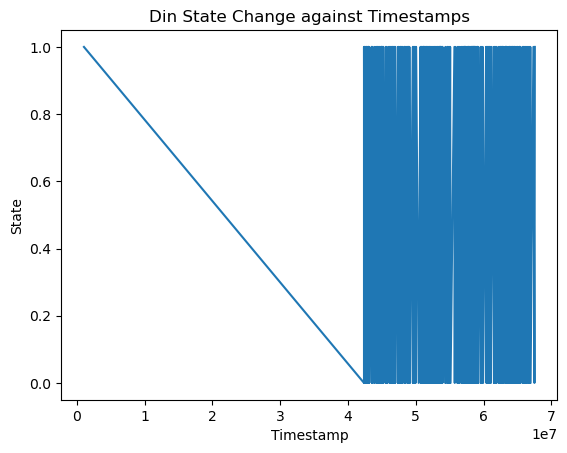

In [42]:
plt.plot([tup[0] for tup in box2_port_entries_DIN_file_name], [tup[1] for tup in box2_port_entries_DIN_file_name])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

## Labeling the Tone and Port Entries

# Syncing with MED-PC

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [43]:
tone_onset_DIN_state_array

array([( 1049104, 1), ( 1721402, 0), ( 2921801, 1), ( 3121800, 0),
       ( 4521798, 1), ( 4721798, 0), ( 6321793, 1), ( 6521795, 0),
       ( 7921790, 1), ( 8121790, 0), ( 9421790, 1), ( 9621790, 0),
       (11421788, 1), (11621787, 0), (13321785, 1), (13521784, 0),
       (15121782, 1), (15321781, 0), (16721780, 1), (16921779, 0),
       (18521777, 1), (18721774, 0), (20521771, 1), (20721773, 0),
       (22321771, 1), (22521768, 0), (24721768, 1), (24921767, 0),
       (26521765, 1), (26721762, 0), (28221763, 1), (28421762, 0),
       (30021760, 1), (30221760, 0), (31921758, 1), (32121757, 0),
       (34321752, 1), (34521754, 0), (35921752, 1), (36121751, 0),
       (38921346, 1), (42353344, 0), (43553742, 1), (43753741, 0),
       (45153740, 1), (45353737, 0), (46953737, 1), (47153737, 0),
       (48553736, 1), (48753733, 0), (50053734, 1), (50253733, 0),
       (52053731, 1), (52253730, 0), (53953729, 1), (54153728, 0),
       (55753726, 1), (55953724, 0), (57353724, 1), (57553722,

- Checking to see if 1 or 0 is when the tone plays
    - Dividing by 20000, because we are recording at a sampling rate at 20000

In [44]:
tone_onset_DIN_state_array[0][0]

1049104

In [45]:
tone_onset_DIN_state_array[1][0]

1721402

In [46]:
tone_onset_DIN_state_array[2][0]

2921801

- So the tone starts when the state is "1"
    - This can be seen because the time from 1 to 0 is 10 seconds

In [47]:
(tone_onset_DIN_state_array[1][0] - tone_onset_DIN_state_array[0][0]) / 20000

33.6149

- So the tone starts when the state is "2"
    - This can be seen because the time from 0 to 1 is 60 seconds, the time for one session

In [48]:
(tone_onset_DIN_state_array[2][0] - tone_onset_DIN_state_array[1][0]) / 20000

60.01995

- Getting only the times when the ECU signal was on

In [49]:
tone_din_time = [din_time for din_time, din_state in tone_onset_DIN_state_array if din_state == 1]

In [50]:
len(tone_din_time)

36

In [51]:
tone_din_time[:10]

[1049104,
 2921801,
 4521798,
 6321793,
 7921790,
 9421790,
 11421788,
 13321785,
 15121782,
 16721780]

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [52]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [53]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [54]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [55]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221215_145401_comp_amd_om_6_1_top_4_base_3.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00133',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1671134060955',
 'timestamp_at_creation': '471194',
 'first_timestamp': '1049104',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([  709,   566,   799,   820,   768,   853,   696,   559,   743,   928,  1005,   769,   650,   -82, -1220,   223,    79,   643,   857,   665,   721,   874

- Array of Voltages for each channel

In [56]:
voltage_value_array = raw_recording_fields_text["data"]

In [57]:
voltage_value_array.shape

(66697743,)

In [58]:
voltage_value_array[:5]

array([([  709,   566,   799,   820,   768,   853,   696,   559,   743,   928,  1005,   769,   650,   -82, -1220,   223,    79,   643,   857,   665,   721,   874,   934,   806,   898,   759,   914,   871,   770,   992,   898,   884],),
       ([  694,   658,   736,   779,   947,   845,   700,   515,   796,   909,   939,   773,   742,  -213, -1296,   121,    51,   607,   678,   686,   702,   814,   899,   911,   834,   716,   861,   869,   659,   934,   947,   805],),
       ([  654,   608,   622,   678,   826,   785,   642,   543,   809,   967,   886,   677,   715,  -264, -1374,   104,    38,   638,   696,   755,   675,   748,   884,   731,   775,   567,   770,   711,   607,   840,   914,   737],),
       ([  612,   502,   529,   731,   755,   654,   506,   425,   659,   850,   849,   577,   719,  -294, -1460,    49,    35,   657,   513,   722,   507,   751,   737,   539,   552,   407,   733,   550,   461,   761,   732,   608],),
       ([  558,   276,   480,   589,   468,   546,   442

- Voltage Time Stamps

In [59]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'timestamps.dat', 'raw_group0.dat'])

In [60]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [61]:
voltage_timestamp_array[:5]

array([(1049104,), (1049105,), (1049106,), (1049107,), (1049108,)],
      dtype=[('time', '<u4')])

In [62]:
voltage_timestamp_array[-5:]

array([(67746842,), (67746843,), (67746844,), (67746845,), (67746846,)],
      dtype=[('time', '<u4')])

In [63]:
voltage_timestamp_array.shape

(66697743,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [64]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [65]:
voltage_timestamp_array[:5]

array([1049104, 1049105, 1049106, 1049107, 1049108])

In [66]:
voltage_timestamp_array[-5:]

array([67746842, 67746843, 67746844, 67746845, 67746846])

In [67]:
voltage_timestamp_array.shape

(66697743,)

- Because spike sorting is 0-indexed, we must make all the tone time also 0-indexed. We will do this by subtracting the first index from the ephys recording for all the tone times.

In [68]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time in tone_din_time]

In [69]:
all_tone_unit_time

[0,
 1872697,
 3472694,
 5272689,
 6872686,
 8372686,
 10372684,
 12272681,
 14072678,
 15672676,
 17472673,
 19472667,
 21272667,
 23672664,
 25472661,
 27172659,
 28972656,
 30872654,
 33272648,
 34872648,
 37872242,
 42504638,
 44104636,
 45904633,
 47504632,
 49004630,
 51004627,
 52904625,
 54704622,
 56304620,
 58104616,
 60104616,
 61904614,
 64304611,
 66104608,
 66504210]

- Checking to see what the time looks like for each tone. The first one is 0, so can be ignored. The last one can also be ignored because it's different by a smaller time than the time between tones compared to the previous one 

In [70]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 93.63485,
 173.6347,
 263.63445,
 343.6343,
 418.6343,
 518.6342,
 613.63405,
 703.6339,
 783.6338,
 873.63365,
 973.63335,
 1063.63335,
 1183.6332,
 1273.63305,
 1358.63295,
 1448.6328,
 1543.6327,
 1663.6324,
 1743.6324,
 1893.6121,
 2125.2319,
 2205.2318,
 2295.23165,
 2375.2316,
 2450.2315,
 2550.23135,
 2645.23125,
 2735.2311,
 2815.231,
 2905.2308,
 3005.2308,
 3095.2307,
 3215.23055,
 3305.2304,
 3325.2105]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [71]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [72]:
all_tone_unit_time

[1872697,
 3472694,
 5272689,
 6872686,
 8372686,
 10372684,
 12272681,
 14072678,
 15672676,
 17472673,
 19472667,
 21272667,
 23672664,
 25472661,
 27172659,
 28972656,
 30872654,
 33272648,
 34872648,
 37872242,
 42504638,
 44104636,
 45904633,
 47504632,
 49004630,
 51004627,
 52904625,
 54704622,
 56304620,
 58104616,
 60104616,
 61904614,
 64304611,
 66104608]

In [73]:
len(all_tone_unit_time)

34

## Seeing which tone belongs to reward training vs competition

- ITI times from MED-PC
    - 60 was not part of the list, but it is the inital delay of the tone from the start of the program

In [74]:
iti_times = [60, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]

- The number of reward trials and competition trials(along with what minute each happened)

```
Reward Trials
    0:       57.000
     1:       58.000
     2:        0.000
     3:        1.000
     4:        2.000
     5:        4.000
     6:        6.000
     7:        7.000
     8:        8.000
     9:       10.000
    10:       12.000
    11:       13.000
    12:       15.000
    13:       17.000
Competition Trials
     0:       19.000
     1:       20.000
     2:       22.000
     3:       23.000
     4:       24.000
     5:       26.000
     6:       28.000
     7:       29.000
     8:       31.000
     9:       32.000
    10:       34.000
    11:       35.000
    12:       37.000
    13:       39.000
    14:       40.000
    15:       42.000
    16:       43.000
    17:       45.000
    18:       47.000
```

In [75]:
previous_time = 0
for index, (time) in enumerate(all_tone_unit_time):
    print("Current Index: {} Current Time: {} Time Difference: {}".format(index, time, (time - previous_time) / 20000))
    previous_time = time

Current Index: 0 Current Time: 1872697 Time Difference: 93.63485
Current Index: 1 Current Time: 3472694 Time Difference: 79.99985
Current Index: 2 Current Time: 5272689 Time Difference: 89.99975
Current Index: 3 Current Time: 6872686 Time Difference: 79.99985
Current Index: 4 Current Time: 8372686 Time Difference: 75.0
Current Index: 5 Current Time: 10372684 Time Difference: 99.9999
Current Index: 6 Current Time: 12272681 Time Difference: 94.99985
Current Index: 7 Current Time: 14072678 Time Difference: 89.99985
Current Index: 8 Current Time: 15672676 Time Difference: 79.9999
Current Index: 9 Current Time: 17472673 Time Difference: 89.99985
Current Index: 10 Current Time: 19472667 Time Difference: 99.9997
Current Index: 11 Current Time: 21272667 Time Difference: 90.0
Current Index: 12 Current Time: 23672664 Time Difference: 119.99985
Current Index: 13 Current Time: 25472661 Time Difference: 89.99985
Current Index: 14 Current Time: 27172659 Time Difference: 84.9999
Current Index: 15 Cur

1. To get the tones that correspond to the first part(training), see where the first 70(60 + 10 to include tone for first tone) occurs
    - This is index 0
2. Then get all the tones until you reach the number of training tones(14)
3. Then starting off at the last index of the first part, see where the first 70(60 + 10 to include tone for first tone) occurs again
    - This is index 32
2. Then get all the tones until you reach the number of training tones(19)

In [76]:
# Skipping one because that is when the system was turned on and off when switching programs
competition_trials = all_tone_unit_time[:19]
training_trials = all_tone_unit_time[20:]

In [77]:
training_and_competition_trials = training_trials + competition_trials

In [78]:
len(training_trials)

14

In [79]:
len(competition_trials)

19

In [80]:
len(training_and_competition_trials)

33

In [81]:
training_trials

[42504638,
 44104636,
 45904633,
 47504632,
 49004630,
 51004627,
 52904625,
 54704622,
 56304620,
 58104616,
 60104616,
 61904614,
 64304611,
 66104608]

In [82]:
competition_trials

[1872697,
 3472694,
 5272689,
 6872686,
 8372686,
 10372684,
 12272681,
 14072678,
 15672676,
 17472673,
 19472667,
 21272667,
 23672664,
 25472661,
 27172659,
 28972656,
 30872654,
 33272648,
 34872648]

## Categorizing Rewarded vs Omitted for Training

In [83]:
rewarded_trials = ["rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded"]

In [84]:
tone_to_reward = {}
for tone_time, reward_bool in zip(training_trials, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [85]:
tone_to_reward

{42504638: 'rewarded',
 44104636: 'rewarded',
 45904633: 'rewarded',
 47504632: 'omission',
 49004630: 'rewarded',
 51004627: 'rewarded',
 52904625: 'rewarded',
 54704622: 'rewarded',
 56304620: 'omission',
 58104616: 'rewarded',
 60104616: 'rewarded',
 61904614: 'omission',
 64304611: 'rewarded',
 66104608: 'rewarded'}

In [86]:
len(tone_to_reward)

14

## Categorizing win vs loss for competition

- Getting trial times to look over in the video

In [87]:
competition_times = [time / 20000 for time in competition_trials]

In [88]:
for index, time in enumerate(competition_times):
    print("Trial {} Minute {} Seconds {}".format(index + 1, time//60, time%60))

Trial 1 Minute 1.0 Seconds 33.63485
Trial 2 Minute 2.0 Seconds 53.63470000000001
Trial 3 Minute 4.0 Seconds 23.634450000000015
Trial 4 Minute 5.0 Seconds 43.634299999999996
Trial 5 Minute 6.0 Seconds 58.634299999999996
Trial 6 Minute 8.0 Seconds 38.634199999999964
Trial 7 Minute 10.0 Seconds 13.634050000000002
Trial 8 Minute 11.0 Seconds 43.63390000000004
Trial 9 Minute 13.0 Seconds 3.633799999999951
Trial 10 Minute 14.0 Seconds 33.63364999999999
Trial 11 Minute 16.0 Seconds 13.63334999999995
Trial 12 Minute 17.0 Seconds 43.633350000000064
Trial 13 Minute 19.0 Seconds 43.63319999999999
Trial 14 Minute 21.0 Seconds 13.633049999999912
Trial 15 Minute 22.0 Seconds 38.63294999999994
Trial 16 Minute 24.0 Seconds 8.632800000000088
Trial 17 Minute 25.0 Seconds 43.63270000000011
Trial 18 Minute 27.0 Seconds 43.63239999999996
Trial 19 Minute 29.0 Seconds 3.6323999999999614


- Labeled win or loss based on looking at the video

In [89]:
winning_trials = ["loss", "win", "win", "win", "win", "win", "win", "win", "win", "win", "win", "win", "loss", "loss", "loss", "loss", "win", "loss", "loss"]

In [90]:
for index, trial in enumerate(winning_trials):
    print("Trial Number: {} Win or Loss for Subject: {}".format(index + 1, trial))

Trial Number: 1 Win or Loss for Subject: loss
Trial Number: 2 Win or Loss for Subject: win
Trial Number: 3 Win or Loss for Subject: win
Trial Number: 4 Win or Loss for Subject: win
Trial Number: 5 Win or Loss for Subject: win
Trial Number: 6 Win or Loss for Subject: win
Trial Number: 7 Win or Loss for Subject: win
Trial Number: 8 Win or Loss for Subject: win
Trial Number: 9 Win or Loss for Subject: win
Trial Number: 10 Win or Loss for Subject: win
Trial Number: 11 Win or Loss for Subject: win
Trial Number: 12 Win or Loss for Subject: win
Trial Number: 13 Win or Loss for Subject: loss
Trial Number: 14 Win or Loss for Subject: loss
Trial Number: 15 Win or Loss for Subject: loss
Trial Number: 16 Win or Loss for Subject: loss
Trial Number: 17 Win or Loss for Subject: win
Trial Number: 18 Win or Loss for Subject: loss
Trial Number: 19 Win or Loss for Subject: loss


In [91]:
tone_to_win = {}
for tone_time, win_bool in zip(competition_trials, winning_trials):
    tone_to_win[tone_time] = win_bool

In [92]:
tone_to_win

{1872697: 'loss',
 3472694: 'win',
 5272689: 'win',
 6872686: 'win',
 8372686: 'win',
 10372684: 'win',
 12272681: 'win',
 14072678: 'win',
 15672676: 'win',
 17472673: 'win',
 19472667: 'win',
 21272667: 'win',
 23672664: 'loss',
 25472661: 'loss',
 27172659: 'loss',
 28972656: 'loss',
 30872654: 'win',
 33272648: 'loss',
 34872648: 'loss'}

## Exporting the tone labels

In [93]:
tone_to_rewarded_or_won_label = {**tone_to_reward, **tone_to_win}

In [94]:
tone_to_rewarded_or_won_label

{42504638: 'rewarded',
 44104636: 'rewarded',
 45904633: 'rewarded',
 47504632: 'omission',
 49004630: 'rewarded',
 51004627: 'rewarded',
 52904625: 'rewarded',
 54704622: 'rewarded',
 56304620: 'omission',
 58104616: 'rewarded',
 60104616: 'rewarded',
 61904614: 'omission',
 64304611: 'rewarded',
 66104608: 'rewarded',
 1872697: 'loss',
 3472694: 'win',
 5272689: 'win',
 6872686: 'win',
 8372686: 'win',
 10372684: 'win',
 12272681: 'win',
 14072678: 'win',
 15672676: 'win',
 17472673: 'win',
 19472667: 'win',
 21272667: 'win',
 23672664: 'loss',
 25472661: 'loss',
 27172659: 'loss',
 28972656: 'loss',
 30872654: 'win',
 33272648: 'loss',
 34872648: 'loss'}

In [95]:
tone_label_df = pd.DataFrame.from_dict(tone_to_rewarded_or_won_label, orient="index").reset_index()
tone_label_df = tone_label_df.rename(columns={"index": "tone_time_stamp", 0: "tone_category"})

In [96]:
tone_label_df

,tone_time_stamp,tone_category
0,42504638,rewarded
1,44104636,rewarded
2,45904633,rewarded
3,47504632,omission
4,49004630,rewarded
5,51004627,rewarded
6,52904625,rewarded
7,54704622,rewarded
8,56304620,omission
9,58104616,rewarded


In [97]:
tone_label_output_path = "./proc/{}_tone_label_df.csv".format(os.path.splitext(raw_recording_fields_text["original_file"])[0])

In [98]:
tone_label_output_path

'./proc/20221215_145401_comp_amd_om_6_1_top_4_base_3_tone_label_df.csv'

In [99]:
tone_label_df.to_csv(tone_label_output_path)

In [100]:
tone_label_df["tone_time_stamp"] / 20000

0     2125.23190
1     2205.23180
2     2295.23165
3     2375.23160
4     2450.23150
5     2550.23135
6     2645.23125
7     2735.23110
8     2815.23100
9     2905.23080
10    3005.23080
11    3095.23070
12    3215.23055
13    3305.23040
14      93.63485
15     173.63470
16     263.63445
17     343.63430
18     418.63430
19     518.63420
20     613.63405
21     703.63390
22     783.63380
23     873.63365
24     973.63335
25    1063.63335
26    1183.63320
27    1273.63305
28    1358.63295
29    1448.63280
30    1543.63270
31    1663.63240
32    1743.63240
Name: tone_time_stamp, dtype: float64